In [1]:
import pandas as pd
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Is gpu available?', device=='cuda')
from transformers import AutoTokenizer
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

#import os
#import numpy as np
#import matplotlib.pyplot as plt

#from transformers import EvalPrediction
#from datasets import load_dataset

Is gpu available? True


In [2]:
train_df = pd.read_csv('../reformat_data/train_wide.csv')
val_df = pd.read_csv('../reformat_data/val_wide.csv')
test_df = pd.read_csv('../reformat_data/test_wide.csv')
train_df.head()

,Text,Classes,ID,Labels,admiration,amusement,anger,annoyance,approval,caring,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,My favourite food is anything I didn't have to...,27,eebbqej,['neutral'],0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,"Now if he does off himself, everyone will thin...",27,ed00q6i,['neutral'],0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj,['anger'],0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,To make her feel threatened,14,ed7ypvh,['fear'],0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Dirty Southern Wankers,3,ed0bdzj,['annoyance'],0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
PAD = 0
MAX_LEN = 512
dropout = 0.1
batch_size = 16
embedding_size = 1024
max_document_length = 512  # each sentence has until 100 words
#max_size = 5000 # maximum vocabulary size
num_classes = 28
lstm_units = 256
hidden_dim = 256
num_layers = 4  # LSTM layers
epochs = 10
learning_rate = 3e-5

In [4]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

In [5]:
train_tokenized = tokenizer(train_df['Text'].values.tolist(),padding='max_length',truncation=True, max_length=MAX_LEN)
train_tokens = train_tokenized['input_ids']

In [6]:
train_lengths = [sum(mask) for mask in train_tokenized['attention_mask']]

In [7]:
class textData(Dataset):
    def __init__(self, x, lengths, y):
        self.x = x
        self.lengths = lengths
        self.y = y
    def __len__(self):
        return len(self.x)
    def __getitem__(self,idx):
        return torch.Tensor(self.x[idx]), self.lengths[idx], torch.Tensor(self.y.iloc[idx])

In [8]:
train_dataset = textData(train_tokens, train_lengths, train_df.iloc[:,4:])

In [9]:
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True) 

In [10]:
for batch in train_loader:
    print(batch[0].shape)
    print(batch[1].shape)
    print(batch[2].shape)
    break

torch.Size([16, 512])
torch.Size([16])
torch.Size([16, 28])


In [11]:
val_tokenized = tokenizer(val_df['Text'].values.tolist(),padding='max_length',truncation=True, max_length=MAX_LEN)
val_tokens = val_tokenized['input_ids']
val_lengths = [sum(mask) for mask in val_tokenized['attention_mask']]
val_dataset = textData(val_tokens, val_lengths, val_df.iloc[:,4:])
val_loader = DataLoader(val_dataset, batch_size = batch_size) 
for batch in val_loader:
    print(batch[0].shape)
    print(batch[1].shape)
    print(batch[2].shape)
    break

torch.Size([16, 512])
torch.Size([16])
torch.Size([16, 28])


In [12]:
test_tokenized = tokenizer(test_df['Text'].values.tolist(),padding='max_length',truncation=True, max_length=MAX_LEN)
test_tokens = test_tokenized['input_ids']
test_lengths = [sum(mask) for mask in test_tokenized['attention_mask']]
test_dataset = textData(test_tokens, test_lengths, test_df.iloc[:,4:])
test_loader = DataLoader(test_dataset, batch_size = batch_size) 


In [13]:
vocab_size = max([max(sample) for sample in train_tokens]
                 +[max(sample) for sample in val_tokens]
                 +[max(sample) for sample in test_tokens]) + 1
print(vocab_size)

28732


In [14]:
class biLSTM(nn.Module):
    def __init__(self, vocab_size, emb_dim, lstm_units, hidden_dim, num_classes, num_layers, dropout = 0, pad_idx = PAD):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(emb_dim, lstm_units, num_layers=num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.fc1 = nn.Linear(2*lstm_units, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        self.relu=nn.ReLU()
        self.drop=nn.Dropout(dropout)
    def forward(self, x, lengths):
        B = x.shape[0]
        x = self.emb(x)
        x = pack_padded_sequence(x, lengths, batch_first = True ,enforce_sorted=False)
        y, _ = self.lstm(x)
        y, _ = pad_packed_sequence(y, batch_first = True)
        y = y[torch.arange(B),lengths-1,:]
        y = self.relu(y)
        y = self.fc1(y)
        y = self.drop(y)
        y = self.fc2(y)
        return y
        

In [15]:
model = biLSTM(vocab_size, embedding_size, lstm_units, hidden_dim, num_classes, num_layers).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)
loss_fn = nn.BCEWithLogitsLoss()

In [16]:
## Train the model
history = {'train_loss':[], 'val_loss':[]}

for epoch in range(epochs):
    # First the training phase
    optimizer.zero_grad()
    model.train()
    train_loss = 0.0
    for x, lengths, y in train_loader:
        #optimizer.zero_grad()
        x, y = x.long().to(device), y.to(device) # Check if lengths is needed
        pred = model(x,lengths)
        loss = loss_fn(pred,y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss+=loss.item()
    train_loss/= len(train_loader)
    history['train_loss'].append(train_loss)

    # Now do evaluation
    model.eval()
    val_loss = 0.0
    for x, lengths, y in val_loader:
        #optimizer.zero_grad()
        x, y = x.long().to(device), y.to(device) # Check if lengths is needed
        pred = model(x,lengths)
        loss = loss_fn(pred,y)
        val_loss+=loss.item()
    val_loss/= len(val_loader)
    
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}", f"Validation Loss: {val_loss:.4f}")
    
    if history['val_loss'] and val_loss>max(history['val_loss'][-2:]):
        print('early stopping')
        history['val_loss'].append(val_loss)
        break
    if history['val_loss'] and val_loss<history['val_loss'][-1]:
        torch.save(model, 'biLSTM.pk')
        
    history['val_loss'].append(val_loss)



Epoch 1/10
Train Loss: 0.1656 Validation Loss: 0.1495
Epoch 2/10
Train Loss: 0.1462 Validation Loss: 0.1402
Epoch 3/10
Train Loss: 0.1368 Validation Loss: 0.1345
Epoch 4/10
Train Loss: 0.1311 Validation Loss: 0.1304
Epoch 5/10
Train Loss: 0.1246 Validation Loss: 0.1258
Epoch 6/10
Train Loss: 0.1183 Validation Loss: 0.1231
Epoch 7/10
Train Loss: 0.1130 Validation Loss: 0.1213
Epoch 8/10
Train Loss: 0.1068 Validation Loss: 0.1195
Epoch 9/10
Train Loss: 0.1012 Validation Loss: 0.1198
Epoch 10/10
Train Loss: 0.0958 Validation Loss: 0.1200
early stopping


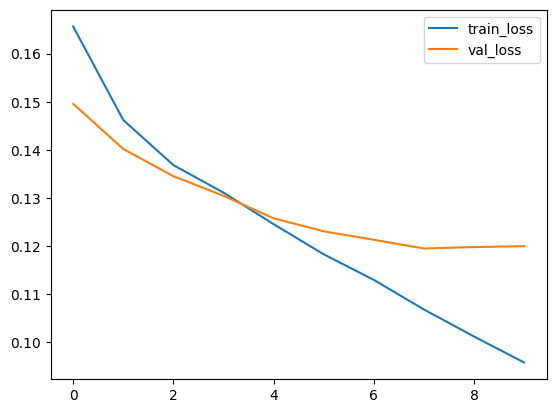

In [19]:
import matplotlib.pyplot as plt
plt.plot(history['train_loss'],label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.legend()
plt.show()

## Evaluate the model

In [20]:
import numpy as np
threshold = 0.5
model = torch.load('biLSTM.pk').to(device)
model.eval()
pred_df = test_df.iloc[:,4:]
batch_start_idx = 0
for x, lengths, y in test_loader:
    x = x.long().to(device) # Check if lengths is needed
    B = x.shape[0]
    df_idx = np.arange(batch_start_idx,batch_start_idx+B)
    batch_start_idx+=B
    pred = model(x,lengths)
    #print(pred)
    label_pred = (nn.Sigmoid()(pred)>=threshold).cpu().long()
    pred_df.loc[df_idx,:] = np.array(label_pred)

In [21]:
f1_micro_average = f1_score(test_df.iloc[:,4:],pred_df, average='micro')
roc_auc = roc_auc_score(test_df.iloc[:,4:], pred_df, average = 'micro')
accuracy = accuracy_score(test_df.iloc[:,4:], pred_df)
# return as dictionary
metrics = {'f1': f1_micro_average,
           'roc_auc': roc_auc,
           'accuracy': accuracy}
print(metrics)

{'f1': 0.40128874569492284, 'roc_auc': 0.6397032184559917, 'accuracy': 0.2839506172839506}


This result is similar to the numbers reported in the paper "GoEmotions: A dataset of fine-grained emotions" https://arxiv.org/pdf/2005.00547.pdf